## Import libraries

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import random
from typing import Dict

from torch import nn, optim, Tensor, torch
from torch_geometric.utils.num_nodes import maybe_num_nodes

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch_geometric.loader import DataLoader
from torch_geometric.utils import negative_sampling
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator 
from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit

import subprocess as sp
import os

from graphsage.graphsage import GNNStack, LinkPredictor, train, test
from data_loaders.data_loader_graphsage import UserUserDatasetGraphSAGE

In [2]:
torch.__version__

'2.1.1+cu118'

In [3]:
torch.device('cuda')

device(type='cuda')

In [4]:
print(torch.cuda.is_available()) 

True


## Import data

In [5]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')
postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

datasets_dict = {
    "postings": postings,
    "votes": votes
}

# Create UserUser dataset for GraphSAGE model

In [7]:
from data_loaders.data_loader_graphsage import UserUserDatasetGraphSAGE
from graphsage.graphsage import GNNStack, LinkPredictor, train, test
from ogb.linkproppred import Evaluator
import subprocess as sp 

In [8]:
uu_dataset_graphsage = UserUserDatasetGraphSAGE(datasets_dict = datasets_dict, verbose = True)

User-article interaction dataframe created with 895196 rows
User-article interaction dataframe subsampled to 447598 rows
Graph created with 33557 nodes and 447598 edges


In [9]:
split_edge = uu_dataset_graphsage.create_train_test_split(uu_dataset_graphsage.graph.edge_index.t())

29332 4225


/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/data_loaders/data_loader_graphsage.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)],


Train edges:  torch.Size([2, 358078])
Valid positive edges:  torch.Size([2, 44760])
Valid negative edges:  torch.Size([2, 44760])
Test positive edges:  torch.Size([2, 44760])
Test negative edges:  torch.Size([2, 44760])


# Run training loop

In [16]:
torch.cuda.is_available()

True

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optim_wd = 0
epochs = 50
hidden_dim = 256
dropout = 0.3
num_layers = 2
lr = 5e-4
node_emb_dim = 256
batch_size = 16*1024

In [18]:
pos_train_edge = split_edge['train']['edge'].to(device)
num_nodes = len(np.unique(uu_dataset_graphsage.graph.edge_index))
emb = torch.nn.Embedding(num_nodes, node_emb_dim).to(device) # each node has an embedding that has to be learnt
model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device)
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)

In [19]:
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

In [20]:
get_gpu_memory()

[1630]

In [21]:


evaluator = Evaluator(name='ogbl-ddi')

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(link_predictor.parameters()) + list(emb.parameters()),
    lr=lr, weight_decay=optim_wd
)
edge_index = uu_dataset_graphsage.edge_index.to(device)

train_loss = []
loss_val_pos_list = []
loss_val_neg_list = []
loss_test_pos_list = []
loss_test_neg_list = []
hits_20 = []
hits_50 = []
hits_100 = []
roc_auc_val = []
roc_auc_test = []

val_hits = []
test_hits = []
for e in tqdm(range(epochs)):
    loss = train(model, link_predictor, emb.weight, edge_index, pos_train_edge, batch_size, optimizer)
    train_loss.append(loss)
    if (e+1)%50 == 0:
        print(f"Epoch {e + 1}: loss: {round(loss, 5)}")
    
    result = test(model, link_predictor, emb.weight, edge_index, split_edge, batch_size, evaluator)
    
    loss_val_pos_list.append(result["loss_val_pos"])
    loss_val_neg_list.append(result["loss_val_neg"])
    loss_test_pos_list.append(result["loss_test_pos"])
    loss_test_neg_list.append(result["loss_test_neg"])
    hits_20.append(result["Hits@20"])
    hits_50.append(result["Hits@50"])
    hits_100.append(result["Hits@100"])
    roc_auc_val.append(result["roc_auc_val"])
    roc_auc_test.append(result["roc_auc_test"])

  0%|          | 0/50 [00:00<?, ?it/s]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0
100%|██████████| 22/22 [00:08<00:00,  2.74it/s]


Train loss:  1.3494109186259182


  2%|▏         | 1/50 [00:08<06:58,  8.54s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3830)
Loss val neg:  tensor(0.8745)
Loss test pos:  tensor(0.3860)
Loss test neg:  tensor(0.8758)
ROC-AUC val:  0.7603268761465178
ROC-AUC test:  0.7582612749079392


100%|██████████| 22/22 [00:07<00:00,  2.83it/s]


Train loss:  1.12886503609744


  4%|▍         | 2/50 [00:16<06:40,  8.34s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3182)
Loss val neg:  tensor(0.7571)
Loss test pos:  tensor(0.3190)
Loss test neg:  tensor(0.7582)
ROC-AUC val:  0.8386067668714328
ROC-AUC test:  0.8388838792994671


100%|██████████| 22/22 [00:05<00:00,  3.74it/s]


Train loss:  1.0278654152696782


  6%|▌         | 3/50 [00:23<05:49,  7.44s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3233)
Loss val neg:  tensor(0.7071)
Loss test pos:  tensor(0.3241)
Loss test neg:  tensor(0.7062)
ROC-AUC val:  0.8474580270628138
ROC-AUC test:  0.8485403504421556


100%|██████████| 22/22 [00:08<00:00,  2.73it/s]


Train loss:  1.0007305416193875


  8%|▊         | 4/50 [00:31<06:01,  7.86s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3141)
Loss val neg:  tensor(0.7037)
Loss test pos:  tensor(0.3144)
Loss test neg:  tensor(0.7019)
ROC-AUC val:  0.8497982565241211
ROC-AUC test:  0.8514581496508835


100%|██████████| 22/22 [00:06<00:00,  3.49it/s]


Train loss:  0.9856618669900027


 10%|█         | 5/50 [00:38<05:37,  7.49s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3290)
Loss val neg:  tensor(0.6703)
Loss test pos:  tensor(0.3294)
Loss test neg:  tensor(0.6686)
ROC-AUC val:  0.8512978635035751
ROC-AUC test:  0.8526445610828


100%|██████████| 22/22 [00:08<00:00,  2.49it/s]


Train loss:  0.9812710583209991


 12%|█▏        | 6/50 [00:47<05:57,  8.13s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3447)
Loss val neg:  tensor(0.6421)
Loss test pos:  tensor(0.3453)
Loss test neg:  tensor(0.6403)
ROC-AUC val:  0.8520440791958861
ROC-AUC test:  0.8534527426485092


100%|██████████| 22/22 [00:09<00:00,  2.22it/s]


Train loss:  0.9730843197215687


 14%|█▍        | 7/50 [00:58<06:22,  8.89s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3316)
Loss val neg:  tensor(0.6577)
Loss test pos:  tensor(0.3322)
Loss test neg:  tensor(0.6552)
ROC-AUC val:  0.8524831770834581
ROC-AUC test:  0.8539997370046664


100%|██████████| 22/22 [00:09<00:00,  2.22it/s]


Train loss:  0.9701411155137148


 16%|█▌        | 8/50 [01:08<06:35,  9.41s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3511)
Loss val neg:  tensor(0.6268)
Loss test pos:  tensor(0.3515)
Loss test neg:  tensor(0.6249)
ROC-AUC val:  0.8530340687020279
ROC-AUC test:  0.8545052430857534


100%|██████████| 22/22 [00:10<00:00,  2.20it/s]


Train loss:  0.9653773009777069


 18%|█▊        | 9/50 [01:19<06:40,  9.78s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3503)
Loss val neg:  tensor(0.6231)
Loss test pos:  tensor(0.3510)
Loss test neg:  tensor(0.6206)
ROC-AUC val:  0.853445177726746
ROC-AUC test:  0.8549459392102932


100%|██████████| 22/22 [00:09<00:00,  2.20it/s]


Train loss:  0.9612208090045236


 20%|██        | 10/50 [01:29<06:40, 10.02s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3536)
Loss val neg:  tensor(0.6192)
Loss test pos:  tensor(0.3544)
Loss test neg:  tensor(0.6167)
ROC-AUC val:  0.8536325842383687
ROC-AUC test:  0.8551399615344992


100%|██████████| 22/22 [00:09<00:00,  2.20it/s]


Train loss:  0.9600513685833324


 22%|██▏       | 11/50 [01:40<06:37, 10.19s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3458)
Loss val neg:  tensor(0.6294)
Loss test pos:  tensor(0.3463)
Loss test neg:  tensor(0.6271)
ROC-AUC val:  0.8536886033924552
ROC-AUC test:  0.8552942153604848


100%|██████████| 22/22 [00:09<00:00,  2.20it/s]


Train loss:  0.9555361785671928


 24%|██▍       | 12/50 [01:51<06:31, 10.31s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3495)
Loss val neg:  tensor(0.6211)
Loss test pos:  tensor(0.3503)
Loss test neg:  tensor(0.6184)
ROC-AUC val:  0.854123375508421
ROC-AUC test:  0.8557388529210701


100%|██████████| 22/22 [00:09<00:00,  2.20it/s]


Train loss:  0.9551045894622803


 26%|██▌       | 13/50 [02:01<06:24, 10.39s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3513)
Loss val neg:  tensor(0.6181)
Loss test pos:  tensor(0.3519)
Loss test neg:  tensor(0.6154)
ROC-AUC val:  0.8543512191123985
ROC-AUC test:  0.8560550492808034


100%|██████████| 22/22 [00:09<00:00,  2.44it/s]


Train loss:  0.9551994069056078


 28%|██▊       | 14/50 [02:11<06:03, 10.10s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3601)
Loss val neg:  tensor(0.6028)
Loss test pos:  tensor(0.3605)
Loss test neg:  tensor(0.6005)
ROC-AUC val:  0.8547396767967537
ROC-AUC test:  0.8563341435326607


100%|██████████| 22/22 [00:07<00:00,  2.82it/s]


Train loss:  0.9517302404750477


 30%|███       | 15/50 [02:19<05:33,  9.54s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3823)
Loss val neg:  tensor(0.5728)
Loss test pos:  tensor(0.3826)
Loss test neg:  tensor(0.5706)
ROC-AUC val:  0.8549240642776768
ROC-AUC test:  0.856631923231118


100%|██████████| 22/22 [00:07<00:00,  2.82it/s]


Train loss:  0.9516716762022539


 32%|███▏      | 16/50 [02:27<05:11,  9.15s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3635)
Loss val neg:  tensor(0.5970)
Loss test pos:  tensor(0.3640)
Loss test neg:  tensor(0.5943)
ROC-AUC val:  0.8550519891212074
ROC-AUC test:  0.8567609202211217


100%|██████████| 22/22 [00:07<00:00,  2.79it/s]


Train loss:  0.9463833218271082


 34%|███▍      | 17/50 [02:35<04:54,  8.92s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3660)
Loss val neg:  tensor(0.5913)
Loss test pos:  tensor(0.3663)
Loss test neg:  tensor(0.5891)
ROC-AUC val:  0.8554314985253493
ROC-AUC test:  0.8571122695583874


100%|██████████| 22/22 [00:07<00:00,  2.81it/s]


Train loss:  0.9449071911248293
Loss val pos:  tensor(0.3674)
Loss val neg:  tensor(0.5867)
Loss test pos:  tensor(0.3678)
Loss test neg:  tensor(0.5842)
ROC-AUC val:  0.8557511581477941


 36%|███▌      | 18/50 [02:45<04:47,  8.98s/it]

ROC-AUC test:  0.8573452393002976


/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0
100%|██████████| 22/22 [00:08<00:00,  2.69it/s]


Train loss:  0.9448563944209706


 38%|███▊      | 19/50 [02:54<04:39,  9.00s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3776)
Loss val neg:  tensor(0.5726)
Loss test pos:  tensor(0.3783)
Loss test neg:  tensor(0.5703)
ROC-AUC val:  0.8558317777725868
ROC-AUC test:  0.8574405884606691


100%|██████████| 22/22 [00:06<00:00,  3.20it/s]


Train loss:  0.9420831474390897
Loss val pos:  tensor(0.3791)
Loss val neg:  tensor(0.5701)
Loss test pos:  tensor(0.3797)
Loss test neg:  tensor(0.5679)
ROC-AUC val:  0.8560260816101124
ROC-AUC test:  0.8575877575347739


 40%|████      | 20/50 [03:02<04:22,  8.73s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0
100%|██████████| 22/22 [00:06<00:00,  3.42it/s]


Train loss:  0.9424812658266588


 42%|████▏     | 21/50 [03:09<04:00,  8.31s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3769)
Loss val neg:  tensor(0.5778)
Loss test pos:  tensor(0.3773)
Loss test neg:  tensor(0.5757)
ROC-AUC val:  0.8561749452546438
ROC-AUC test:  0.8578709596848967


100%|██████████| 22/22 [00:07<00:00,  3.04it/s]


Train loss:  0.9389515221118927


 44%|████▍     | 22/50 [03:17<03:48,  8.15s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3773)
Loss val neg:  tensor(0.5730)
Loss test pos:  tensor(0.3778)
Loss test neg:  tensor(0.5705)
ROC-AUC val:  0.8562082898584926
ROC-AUC test:  0.8578981137409646


100%|██████████| 22/22 [00:08<00:00,  2.51it/s]


Train loss:  0.9385104369033467


 46%|████▌     | 23/50 [03:26<03:49,  8.50s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3776)
Loss val neg:  tensor(0.5719)
Loss test pos:  tensor(0.3781)
Loss test neg:  tensor(0.5700)
ROC-AUC val:  0.8564900440119121
ROC-AUC test:  0.8580311357724766


100%|██████████| 22/22 [00:08<00:00,  2.47it/s]


Train loss:  0.9346894269639795


 48%|████▊     | 24/50 [03:36<03:48,  8.78s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3695)
Loss val neg:  tensor(0.5821)
Loss test pos:  tensor(0.3698)
Loss test neg:  tensor(0.5797)
ROC-AUC val:  0.856445115434437
ROC-AUC test:  0.8581470970486222


100%|██████████| 22/22 [00:09<00:00,  2.23it/s]


Train loss:  0.9365336082198403


 50%|█████     | 25/50 [03:46<03:51,  9.26s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3938)
Loss val neg:  tensor(0.5512)
Loss test pos:  tensor(0.3944)
Loss test neg:  tensor(0.5494)
ROC-AUC val:  0.8565750116199116
ROC-AUC test:  0.8581557555797537


100%|██████████| 22/22 [00:05<00:00,  3.70it/s]


Train loss:  0.9333676777102731


 52%|█████▏    | 26/50 [03:52<03:21,  8.42s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3759)
Loss val neg:  tensor(0.5738)
Loss test pos:  tensor(0.3763)
Loss test neg:  tensor(0.5716)
ROC-AUC val:  0.8568004266723688
ROC-AUC test:  0.8583244304745956


100%|██████████| 22/22 [00:06<00:00,  3.66it/s]


Train loss:  0.9319094961339777


 54%|█████▍    | 27/50 [03:59<03:00,  7.84s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3948)
Loss val neg:  tensor(0.5462)
Loss test pos:  tensor(0.3952)
Loss test neg:  tensor(0.5441)
ROC-AUC val:  0.8568172932634062
ROC-AUC test:  0.8583942634972659


100%|██████████| 22/22 [00:05<00:00,  3.69it/s]


Train loss:  0.9305491935123097


 56%|█████▌    | 28/50 [04:05<02:43,  7.42s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3846)
Loss val neg:  tensor(0.5610)
Loss test pos:  tensor(0.3852)
Loss test neg:  tensor(0.5592)
ROC-AUC val:  0.8567536425527549
ROC-AUC test:  0.8582367176125913


100%|██████████| 22/22 [00:05<00:00,  3.68it/s]


Train loss:  0.9302746572277762


 58%|█████▊    | 29/50 [04:12<02:30,  7.16s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3800)
Loss val neg:  tensor(0.5656)
Loss test pos:  tensor(0.3807)
Loss test neg:  tensor(0.5639)
ROC-AUC val:  0.8568262897103487
ROC-AUC test:  0.8582296445904319


100%|██████████| 22/22 [00:08<00:00,  2.50it/s]


Train loss:  0.9282178580760956


 60%|██████    | 30/50 [04:21<02:36,  7.82s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4086)
Loss val neg:  tensor(0.5284)
Loss test pos:  tensor(0.4090)
Loss test neg:  tensor(0.5263)
ROC-AUC val:  0.8570332900980784
ROC-AUC test:  0.8586339324076537


100%|██████████| 22/22 [00:08<00:00,  2.51it/s]


Train loss:  0.9278048303994265


 62%|██████▏   | 31/50 [04:31<02:36,  8.26s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3925)
Loss val neg:  tensor(0.5492)
Loss test pos:  tensor(0.3928)
Loss test neg:  tensor(0.5470)
ROC-AUC val:  0.8568571311416823
ROC-AUC test:  0.8585612805082573


100%|██████████| 22/22 [00:08<00:00,  2.50it/s]


Train loss:  0.9260982247916135


 64%|██████▍   | 32/50 [04:40<02:34,  8.59s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3865)
Loss val neg:  tensor(0.5582)
Loss test pos:  tensor(0.3870)
Loss test neg:  tensor(0.5564)
ROC-AUC val:  0.856942405219856
ROC-AUC test:  0.8585144344956439


100%|██████████| 22/22 [00:09<00:00,  2.23it/s]


Train loss:  0.9261548762971704


 66%|██████▌   | 33/50 [04:50<02:35,  9.17s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4005)
Loss val neg:  tensor(0.5383)
Loss test pos:  tensor(0.4012)
Loss test neg:  tensor(0.5365)
ROC-AUC val:  0.8571577339595308
ROC-AUC test:  0.8586540271678322


100%|██████████| 22/22 [00:10<00:00,  2.19it/s]


Train loss:  0.9252392107790167


 68%|██████▊   | 34/50 [05:01<02:33,  9.61s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3977)
Loss val neg:  tensor(0.5401)
Loss test pos:  tensor(0.3984)
Loss test neg:  tensor(0.5381)
ROC-AUC val:  0.8571146931185367
ROC-AUC test:  0.8585844646774656


100%|██████████| 22/22 [00:10<00:00,  2.19it/s]


Train loss:  0.9222045920111916


 70%|███████   | 35/50 [05:12<02:28,  9.92s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3858)
Loss val neg:  tensor(0.5574)
Loss test pos:  tensor(0.3864)
Loss test neg:  tensor(0.5562)
ROC-AUC val:  0.8570822422196507
ROC-AUC test:  0.8584734333783755


100%|██████████| 22/22 [00:10<00:00,  2.18it/s]


Train loss:  0.9236484657634388


 72%|███████▏  | 36/50 [05:22<02:22, 10.15s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3966)
Loss val neg:  tensor(0.5427)
Loss test pos:  tensor(0.3972)
Loss test neg:  tensor(0.5415)
ROC-AUC val:  0.8573445420057804
ROC-AUC test:  0.8585978530316787


100%|██████████| 22/22 [00:10<00:00,  2.18it/s]


Train loss:  0.9219450950622559


 74%|███████▍  | 37/50 [05:33<02:14, 10.32s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3951)
Loss val neg:  tensor(0.5438)
Loss test pos:  tensor(0.3961)
Loss test neg:  tensor(0.5426)
ROC-AUC val:  0.8572930173316371
ROC-AUC test:  0.8585127424209027


100%|██████████| 22/22 [00:09<00:00,  2.38it/s]


Train loss:  0.9209781180728566


 76%|███████▌  | 38/50 [05:43<02:01, 10.14s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3950)
Loss val neg:  tensor(0.5465)
Loss test pos:  tensor(0.3957)
Loss test neg:  tensor(0.5454)
ROC-AUC val:  0.8572729839653207
ROC-AUC test:  0.8585554094082151


100%|██████████| 22/22 [00:07<00:00,  2.79it/s]


Train loss:  0.9210537970066071


 78%|███████▊  | 39/50 [05:51<01:45,  9.61s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3990)
Loss val neg:  tensor(0.5438)
Loss test pos:  tensor(0.3997)
Loss test neg:  tensor(0.5423)
ROC-AUC val:  0.8572728594306164
ROC-AUC test:  0.8587446956701255


100%|██████████| 22/22 [00:05<00:00,  3.71it/s]


Train loss:  0.9199105148965662


 80%|████████  | 40/50 [05:58<01:26,  8.65s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3950)
Loss val neg:  tensor(0.5453)
Loss test pos:  tensor(0.3958)
Loss test neg:  tensor(0.5437)
ROC-AUC val:  0.8574286371221432
ROC-AUC test:  0.858908449073242


100%|██████████| 22/22 [00:05<00:00,  3.69it/s]


Train loss:  0.9170810553160581


 82%|████████▏ | 41/50 [06:04<01:11,  7.99s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3879)
Loss val neg:  tensor(0.5541)
Loss test pos:  tensor(0.3887)
Loss test neg:  tensor(0.5522)
ROC-AUC val:  0.8571984732793947
ROC-AUC test:  0.8585352634864847


100%|██████████| 22/22 [00:08<00:00,  2.55it/s]


Train loss:  0.9173408259044994


 84%|████████▍ | 42/50 [06:13<01:06,  8.35s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3995)
Loss val neg:  tensor(0.5390)
Loss test pos:  tensor(0.4002)
Loss test neg:  tensor(0.5373)
ROC-AUC val:  0.8573020799142442
ROC-AUC test:  0.8587002365310852


100%|██████████| 22/22 [00:08<00:00,  2.48it/s]


Train loss:  0.9162987877022136


 86%|████████▌ | 43/50 [06:23<01:00,  8.67s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.3946)
Loss val neg:  tensor(0.5468)
Loss test pos:  tensor(0.3954)
Loss test neg:  tensor(0.5449)
ROC-AUC val:  0.8573794948293391
ROC-AUC test:  0.8588596821315311


100%|██████████| 22/22 [00:08<00:00,  2.51it/s]


Train loss:  0.9166725223714655


 88%|████████▊ | 44/50 [06:32<00:53,  8.88s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4070)
Loss val neg:  tensor(0.5309)
Loss test pos:  tensor(0.4078)
Loss test neg:  tensor(0.5297)
ROC-AUC val:  0.857481977407458
ROC-AUC test:  0.8589745313302363


100%|██████████| 22/22 [00:10<00:00,  2.12it/s]


Train loss:  0.9139101694930684


 90%|█████████ | 45/50 [06:43<00:47,  9.48s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4010)
Loss val neg:  tensor(0.5383)
Loss test pos:  tensor(0.4015)
Loss test neg:  tensor(0.5372)
ROC-AUC val:  0.8573099732682139
ROC-AUC test:  0.8587373845595734


100%|██████████| 22/22 [00:07<00:00,  2.78it/s]


Train loss:  0.9164523184299469


 92%|█████████▏| 46/50 [06:51<00:36,  9.14s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4210)
Loss val neg:  tensor(0.5160)
Loss test pos:  tensor(0.4217)
Loss test neg:  tensor(0.5149)
ROC-AUC val:  0.8575120269577954
ROC-AUC test:  0.8589423444748718


100%|██████████| 22/22 [00:07<00:00,  2.80it/s]


Train loss:  0.9131223830309781


 94%|█████████▍| 47/50 [07:00<00:26,  8.88s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4027)
Loss val neg:  tensor(0.5386)
Loss test pos:  tensor(0.4034)
Loss test neg:  tensor(0.5375)
ROC-AUC val:  0.8572013036362736
ROC-AUC test:  0.8585296888738749


100%|██████████| 22/22 [00:07<00:00,  2.84it/s]


Train loss:  0.9132516275752675
Loss val pos:  tensor(0.4041)
Loss val neg:  tensor(0.5374)
Loss test pos:  tensor(0.4047)
Loss test neg:  tensor(0.5360)
ROC-AUC val:  0.8572874454642814


 96%|█████████▌| 48/50 [07:09<00:17,  8.91s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


ROC-AUC test:  0.8587205296982576


100%|██████████| 22/22 [00:07<00:00,  2.76it/s]


Train loss:  0.9133414301005277


 98%|█████████▊| 49/50 [07:17<00:08,  8.80s/it]/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_train_edge = torch.tensor(pos_train_edge, dtype=torch.long).T
/home/rgrebnev/Documents/ws_2023/sna/sna_link_prediction/notebooks/graphsage/graphsage.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [edge_index[0], torch.tensor(unique_nodes[rand]).to(edge_index.device)], dim=0


Loss val pos:  tensor(0.4032)
Loss val neg:  tensor(0.5369)
Loss test pos:  tensor(0.4038)
Loss test neg:  tensor(0.5355)
ROC-AUC val:  0.8575759818925042
ROC-AUC test:  0.8590206293859176


100%|██████████| 22/22 [00:06<00:00,  3.61it/s]


Train loss:  0.913126064972444
Epoch 50: loss: 0.91313


100%|██████████| 50/50 [07:24<00:00,  8.88s/it]

Loss val pos:  tensor(0.3996)
Loss val neg:  tensor(0.5427)
Loss test pos:  tensor(0.4003)
Loss test neg:  tensor(0.5415)
ROC-AUC val:  0.8574851332017209
ROC-AUC test:  0.8588300818045763


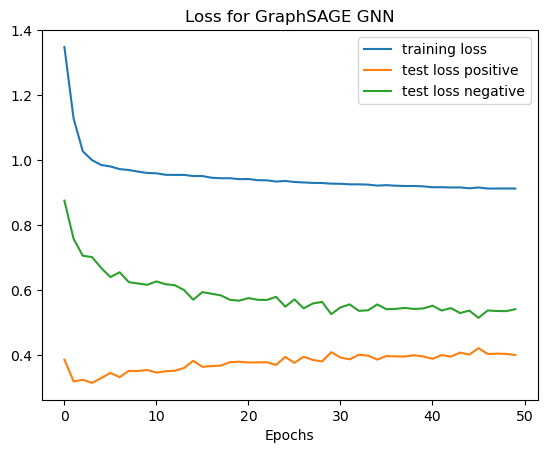

In [23]:
plt.title('Loss for GraphSAGE GNN')
plt.plot(train_loss,label="training loss")
# plt.plot(loss_val_pos_list,label="validation loss positive")
# plt.plot(loss_val_neg_list,label="validation loss negative")
plt.plot(loss_test_pos_list,label="test loss positive")
plt.plot(loss_test_neg_list,label="test loss negative")
plt.xlabel('Epochs')
plt.legend()
plt.show()

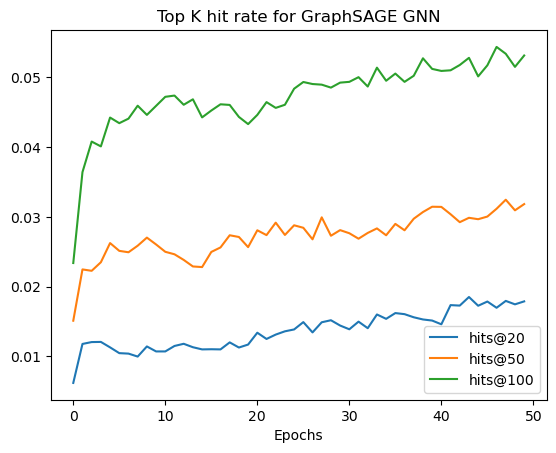

In [36]:
plt.title('Top K hit rate for GraphSAGE GNN')
plt.plot([a for a, b in hits_20],label="hits@20")
plt.plot([a for a, b in hits_50],label="hits@50")
plt.plot([a for a, b in hits_100],label="hits@100")
plt.xlabel('Epochs')
plt.legend()
plt.show()

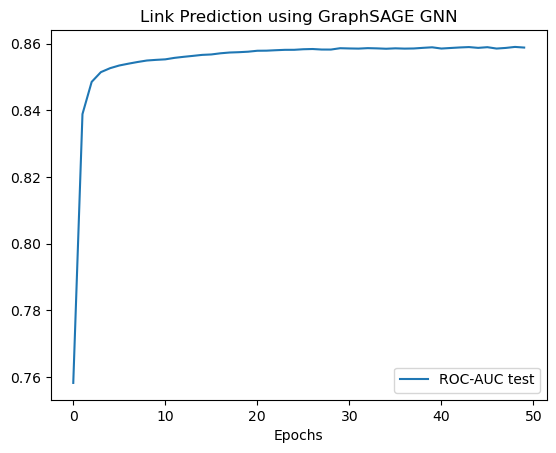

In [38]:
plt.title('Link Prediction using GraphSAGE GNN')
# plt.plot(roc_auc_val,label="ROC-AUC validation")
plt.plot(roc_auc_test,label="ROC-AUC test")
plt.xlabel('Epochs')
plt.legend()
plt.show()